# Convolutionalization

Here, we train a conventional CNN to classify image on cats and dogs based on a part of the [CIFAR10](https://keras.io/datasets/) dataset, identical to day 1.

After training, however, we will convert the trained CNN into a fully convolutional network (FCN) as proposed by [Long et al., 2014](https://arxiv.org/pdf/1411.4038.pdf).

Without the need for any retraining, this new FCN allows us to predict spatial heatmaps for classification instead of classification scores. 



Recommended reading:
- Long et al. (2014) [Fully Convolutional Networks for Semantic Segmentation](https://arxiv.org/pdf/1411.4038.pdf)
- CS231n: [Converting FC layers to CONV layers](https://cs231n.github.io/convolutional-networks/#convert)
- Garcia-Garcia et al. (2017) [A Review on Deep Learning Techniques Applied to Semantic Segmentation](https://arxiv.org/pdf/1704.06857.pdf)

In [1]:
# numpy and plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# keras
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D

from keras.datasets import cifar10
from keras import backend as K

from keras.preprocessing.image import ImageDataGenerator

** Load Cats and Dogs From CIFAR10 dataset **

170508288/170498071 [==============================] - 2s 0us/step
x_train shape: (10000, 32, 32, 3)
10000 train samples
2000 test samples


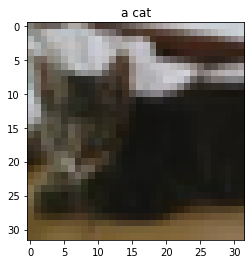

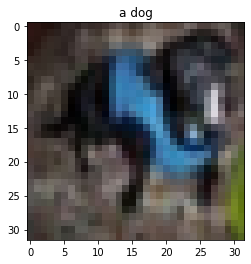

In [2]:
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# Reduce to cats and dogs
def extract(x,y,labels):
    arg_train = []
    new_y = np.zeros(np.max(labels)+1)
    for i,l in enumerate(labels):
        arg_train.append(np.argwhere(y == l)[:,0])
        new_y[l] = i
    arg_train = np.concatenate(arg_train)
    return x[arg_train], new_y[y[arg_train]]
    
x_train, y_train = extract(x_train, y_train, [3,5])
x_test, y_test = extract(x_test, y_test, [3,5])

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# maximum value normalization
x_train /= 255
x_test /= 255

plt.imshow(x_train[np.argmax(y_train==0)])
plt.title("a cat")
plt.show()
plt.imshow(x_train[np.argmax(y_train==1)])
plt.title("a dog")
plt.show()

In [3]:
img_rows, img_cols, channels = x_train.shape[1:]

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], channels, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], channels, img_rows, img_cols)
    input_shape = (channels, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
    input_shape = (img_rows, img_cols, channels)
    
def predict(idx, model, data, avg=None, norm=None, cols=5, threshold=.3):
    try:
        idx = list(idx)
    except:
        idx = [idx]
        
    cats = 0
    dogs = 0
    data = data[idx]
    if norm is None:
        p = model.predict(data)
    else:
        p = model.predict(data/norm)
    i = 0
    while i < p.shape[0]:
        fig, axs = plt.subplots(1,cols,figsize=(5*cols,5))
        fig.figsize=(20,10)
        for ax in axs:
            if avg is not None:
                img = (data[i]+avg)
            else:
                img = (data[i])

            ax.imshow(img)
            if p[i] < threshold:
                label = "cat"
                cats += 1
            elif p[i] > 1-threshold:
                label = "dog"
                dogs += 1
            else:
                label = "not sure"
            ax.text(.5,0, label+ "; score = " + str(p[i]),
                    horizontalalignment='center', verticalalignment='bottom', transform=ax.axes.transAxes,
                    backgroundcolor="white", size="large")
            i += 1
            if i >= p.shape[0]:
                break
        plt.show()
    print(cats, " cats (", cats/len(idx)*100., "%),", dogs, " dogs (", dogs/len(idx)*100., "%)")

In [4]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(K.image_data_format())
print(input_shape)
print(y_train[0])

(10000, 32, 32, 3)
(10000, 1)
(2000, 32, 32, 3)
(2000, 1)
channels_last
(32, 32, 3)
[0.]


In [5]:
batch_size = 128

# Convolutional Neural Network

A very simple CNN... (> 70% validation accuray after 10 epochs)

In [6]:
model_cnn = Sequential()
model_cnn.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 padding='same',
                 input_shape=input_shape))
model_cnn.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.25))
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(1, activation='sigmoid'))

model_cnn.compile(loss="binary_crossentropy",
              optimizer='adam',
              metrics=['accuracy'])

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 128)               2097280   
                                                        

In [7]:
model_cnn.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=20,
              validation_data=(x_test, y_test),
              shuffle=True,
              verbose=2)

Epoch 1/20
79/79 - 14s - loss: 0.7113 - accuracy: 0.5181 - val_loss: 0.6866 - val_accuracy: 0.5640 - 14s/epoch - 172ms/step
Epoch 2/20
79/79 - 1s - loss: 0.6821 - accuracy: 0.5620 - val_loss: 0.6677 - val_accuracy: 0.6125 - 621ms/epoch - 8ms/step
Epoch 3/20
79/79 - 1s - loss: 0.6495 - accuracy: 0.6240 - val_loss: 0.6313 - val_accuracy: 0.6380 - 626ms/epoch - 8ms/step
Epoch 4/20
79/79 - 1s - loss: 0.6250 - accuracy: 0.6497 - val_loss: 0.6070 - val_accuracy: 0.6725 - 621ms/epoch - 8ms/step
Epoch 5/20
79/79 - 1s - loss: 0.6043 - accuracy: 0.6734 - val_loss: 0.5893 - val_accuracy: 0.6880 - 622ms/epoch - 8ms/step
Epoch 6/20
79/79 - 1s - loss: 0.5824 - accuracy: 0.6967 - val_loss: 0.5682 - val_accuracy: 0.7075 - 627ms/epoch - 8ms/step
Epoch 7/20
79/79 - 1s - loss: 0.5640 - accuracy: 0.7084 - val_loss: 0.5640 - val_accuracy: 0.7145 - 619ms/epoch - 8ms/step
Epoch 8/20
79/79 - 1s - loss: 0.5467 - accuracy: 0.7223 - val_loss: 0.5686 - val_accuracy: 0.7150 - 630ms/epoch - 8ms/step
Epoch 9/20
79/7

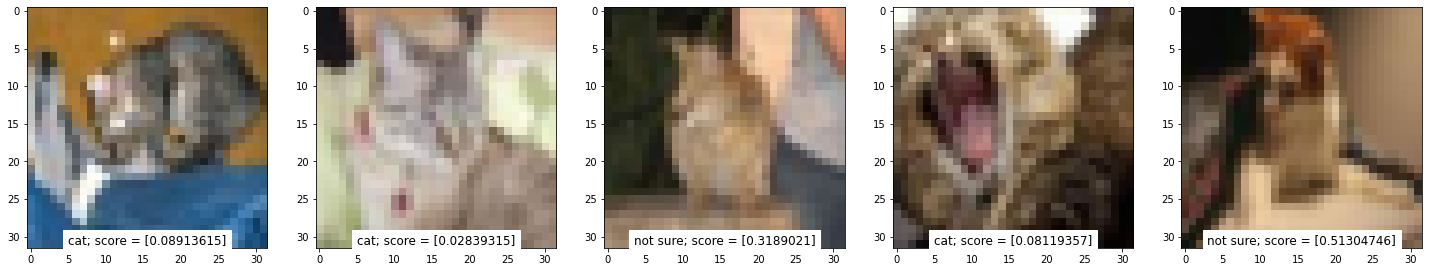

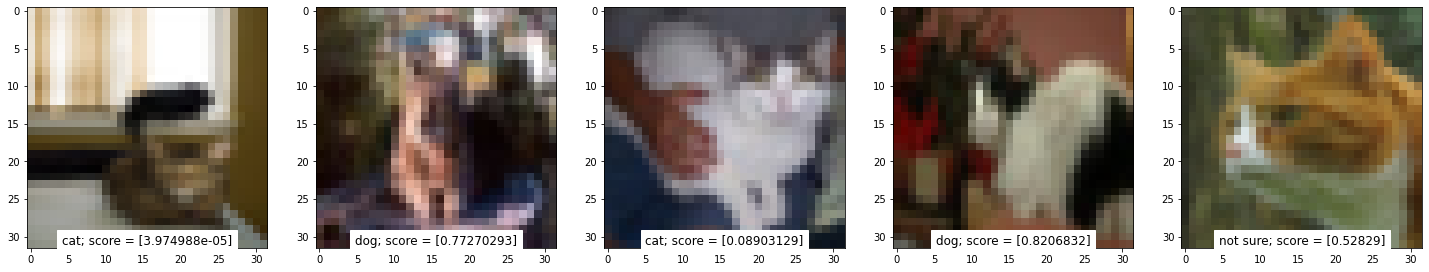

5  cats ( 50.0 %), 2  dogs ( 20.0 %)


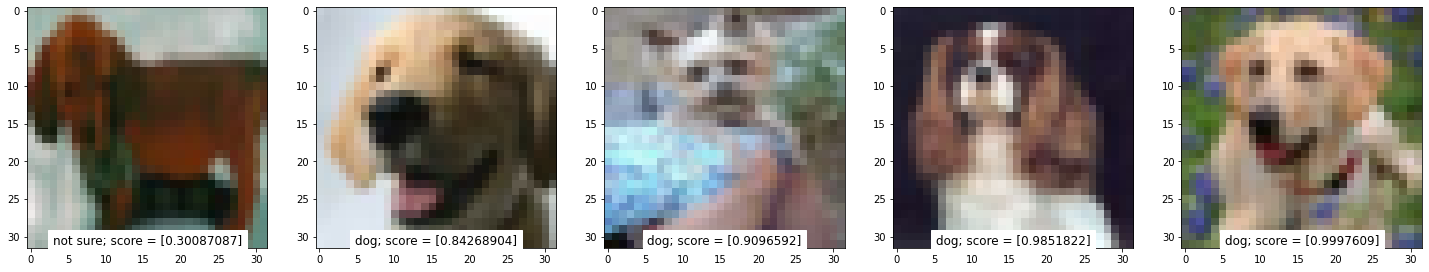

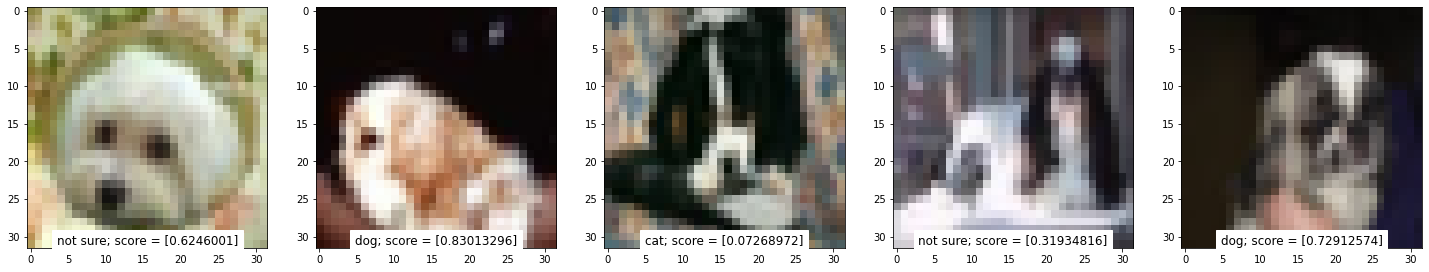

1  cats ( 10.0 %), 6  dogs ( 60.0 %)


In [8]:
predict(range(10), model_cnn, x_test)
predict(range(x_test.shape[0]-10, x_test.shape[0]), model_cnn, x_test)

# Convert CNN into a FCN

Now, we convolutionalize the previously trained CNN model to obtain an identical fully convolutional network (FCN) as proposed by [Long et al., 2014](https://arxiv.org/pdf/1411.4038.pdf).

1. define identical model, but:
  - remove `Flatten` layer
  - replace all `Dense` layers with `Conv2D` layers
  - remove explicit `height` and `width` from `input_shape` such that all image size can be used as input
2. save and load weights from CNN model
3. set weights for all layers, with appropriate reshaping for the new `Conv2D` layers

- define FCN model by e.g. replacing dense with conv2d

In [9]:
# remove explicit height and width from input shape
input_shape_fcn = (None, None, 3)

model_fcn = Sequential()
model_fcn.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 padding='same',
                 input_shape=input_shape_fcn))
model_fcn.add(Conv2D(64, (3, 3), activation='relu'))
model_fcn.add(MaxPooling2D(pool_size=(2, 2)))
model_fcn.add(Dropout(0.25))

##model2.add(Flatten())
##model2.add(Dense(128, activation='relu'))
model_fcn.add(Conv2D(128, (16, 16), activation='relu', padding='valid')) # <- new conv2d layer
model_fcn.add(Dropout(0.5))

##model2.add(Dense(1, activation='sigmoid'))
model_fcn.add(Conv2D(1, (1, 1), activation='sigmoid', padding='valid')) # <- new conv2d layer

model_fcn.compile(loss="binary_crossentropy",
              optimizer='adam',
              metrics=['accuracy'])

model_fcn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, None, None, 32)    896       
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 64)    18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, None, None, 64)   0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, None, None, 64)    0         
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 128)   2097280   
                                                                 
 dropout_3 (Dropout)         (None, None, None, 128)   0         
                                                      

- copy weights form model1 into model2, with appropriate reshaping.

In [10]:
model_cnn.save('model_cnn.h5')
from keras.models import load_model
weights = load_model('model_cnn.h5').get_weights()

In [11]:
model_fcn.layers[0].set_weights([weights[0], weights[1]])
model_fcn.layers[1].set_weights([weights[2], weights[3]])
model_fcn.layers[4].set_weights([weights[4].reshape(16,16,64,128), weights[5]])
model_fcn.layers[6].set_weights([weights[6].reshape(1,1,128,1), weights[7]])

# Predict heatmaps

Note: we do **not** need to retrain the model.

In [12]:

def predict_heatmap(model_cnn, model_fcn, sample, alpha=0.4, threshold=0.3):
    
    ### CNN

    # run inference on image through CNN model
    ## returns prediction of shape 1
    prediction = model_cnn.predict(x_test[sample:sample+1])

    if prediction < threshold:
        label = "Cat"
        score = 1-prediction
    elif prediction > 1-threshold:
        label = "Dog"
        score = prediction
    else:
        label = "Not sure"
        score = prediction
    title = '{} : {:.1%}'.format(label, np.squeeze(score))

    ### FCN
    
    from skimage.transform import rescale, resize

    # get test image, upsample to twice the size
    im_large = rescale(x_test[sample:sample+1], (1, 2, 2, 1), mode='constant', multichannel=False)

    
    # run inference on large image through FCN model
    ## returns prediction of shape 17x17 
    prediction_map = model_fcn.predict(im_large)
    #print(prediction_map.shape)
    
    # resize prediction to size of large image (no interpolation)
    heatmap = np.squeeze(resize(prediction_map, (*im_large.shape[:3], 1), order=0, mode='constant'))
    
    # resize prediction to size of large image (with interpolation)
    heatmap_smooth = np.squeeze(resize(prediction_map, (*im_large.shape[:3], 1), order=1, mode='constant'))

    fig, ax = plt.subplots(1,3,figsize=(10,5))
    fig.suptitle(title, y=(0.9))
    fig.tight_layout()
    ax[0].set_title('Input image')
    ax[0].imshow(np.squeeze(im_large))
    ax[1].set_title('Heatmap')
    ax[1].imshow(heatmap, cmap='jet')

    ax[2].set_title('Overlay')
    ax[2].imshow(np.squeeze(im_large))
    ax[2].imshow(heatmap_smooth, cmap='jet', alpha=alpha)

    for a in ax: a.axis('off')
    
    plt.show()
    plt.close()

def predict_heatmaps(model_cnn, model_fcn, number):
    [predict_heatmap(model_cnn, model_fcn, sample=n) for n in np.random.choice(len(x_test), number)]

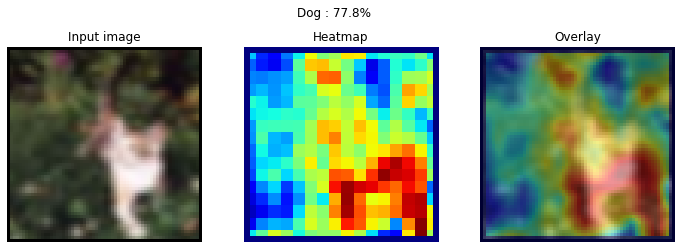

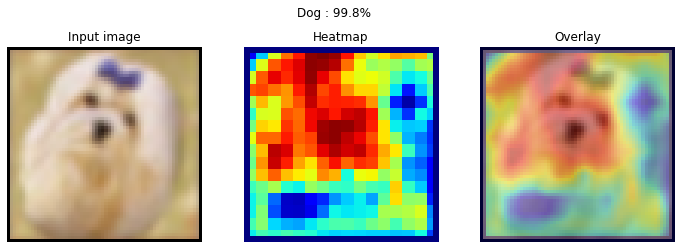

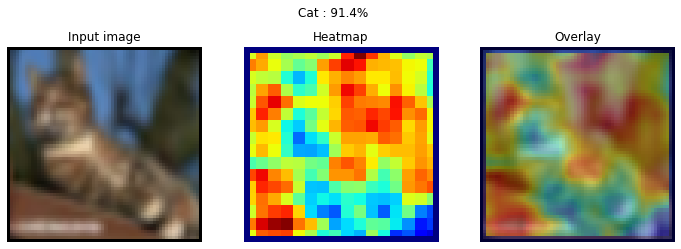

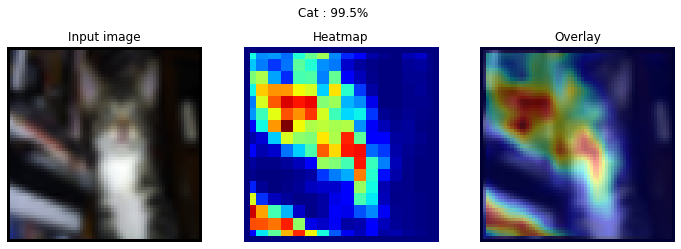

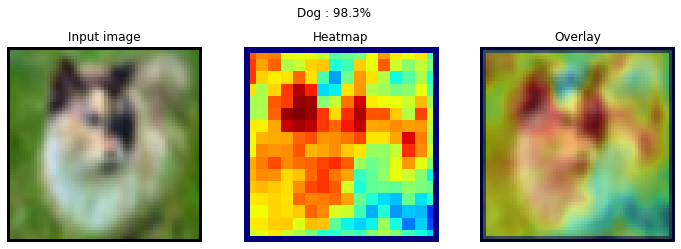

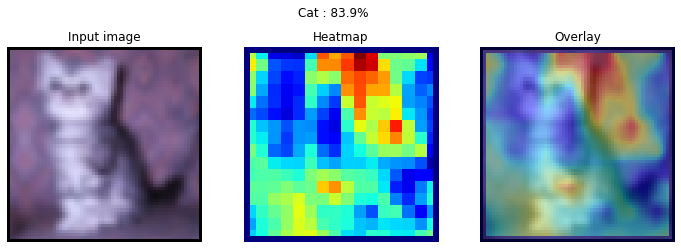

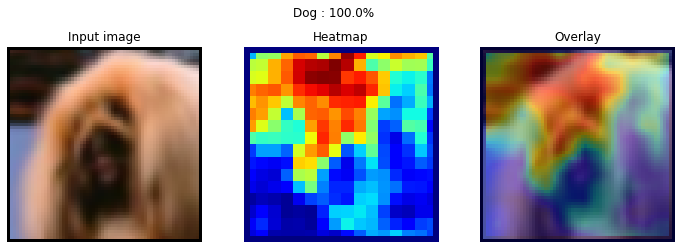

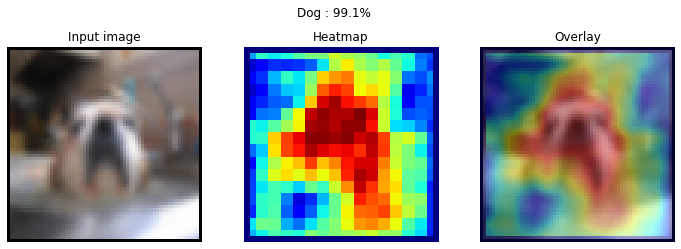

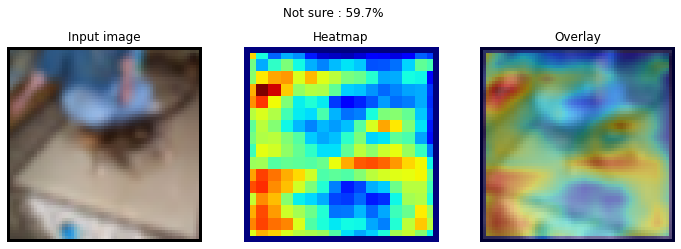

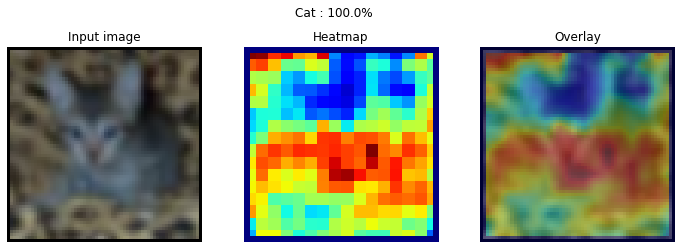

In [13]:
predict_heatmaps(model_cnn, model_fcn, number=10)